In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from scipy.integrate import quadrature

%run ../Utilities/Utilities.ipynb


# Poisson Equation: 1D FEM
### Dirichlet left, dirichlet right

In [2]:
#---------------------Deprecated------------------
def linear_piecewise(xs, us):
    '''
    Create a function object for a piecewise linear function that interpolates a set of points
    xs      : (ndarray) grid points
    us      : (ndarray) function values at the grid points
    
    returns : function object
    '''
    
    def f(x):
        result = np.zeros_like(x)
        for i, xi in enumerate(x):
            if xi in xs:
                result[i] = us[np.where(xs == xi)[0][0]]
            else:
                n = np.where(xs == np.max(np.where(xs < xi, xs, -np.inf)))[0][0]
                result[i] = us[n]*(xi-xs[n+1])/(xs[n] - xs[n+1]) + us[n+1]*(xi-xs[n])/(xs[n+1]-xs[n])
        return result
    return f
#-------------------------------------------------

def H1(u, x):
    return np.sqrt(trapezoid(u**2, x) + trapezoid(np.gradient(u, x)**2, x))

def L2(u, x):
    return np.sqrt(trapezoid(u**2, x))

class Poisson:
    '''
    Contaier for FEM methods for the Poisson eq in 1D with double dirichlet
    
    Members:
      .FEM()
      .AFEM()
    '''
        
    def FEM(x, d_1, d_2, f):
        '''
        Apply FEM to the Poisson equation
        x       : (ndarray) grid to apply FEM over
        d_1     : (float) left boundary condition
        d_2     : (float) right boundary condition
        f       : (fnc) inital condition

        returns : (ndarray) approximate solution
        '''


        N = len(x)-1
        #Make R-vector
        R = np.zeros(N+1)
        R[0] = d_1
        R[-1] = d_2

        #Generate A and F
        A = np.zeros((N+1, N+1))
        F = np.zeros(N+1)
        for k in range(N):
            A[k:k+2, k:k+2] += 1/(x[k+1]-x[k])*np.array([[1,-1],[-1,1]])
            #F[k:k+2] += (x[k+1]-x[k])/2*np.array(f(x[k:k+2])) #trapezoidal
            F[k:k+2] += 1/(x[k+1]-x[k])*np.array([quadrature(lambda xi : (x[k+1]-xi)*f(xi), x[k], x[k+1])[0], quadrature(lambda xi : (xi-x[k])*f(xi), x[k], x[k+1])[0]])
            
        F -= np.matmul(A, R)

        #Remove first and last row and column of A, and first and last element of F 
        A = A[1:-1, 1:-1]
        F = F[1:-1]

        #Solve for u
        u = np.linalg.solve(A, F)

        #Add back R
        u = np.insert(u, [0, len(u)], [d_1, d_2])
        return u

    def AFEM(x, d_1, d_2, f, u_analytic, Nmax, method="max", fig=None, ax=None, gridplots=False, plotExpected=True):
        '''
        Perform adaptive FEM on the poisson equation
        x          : (ndarray) grid to start with
        d_1        : (float) left boundary condition
        d_2        : (float) right boundary condition
        f          : (fnc) right side in the poisson equation
        u_analytic : (fnc) analytic solution
        method     : (str) 'avg' or 'max'. Method for determining which elements to refine
        fig        : (matplotlib.figure) figure to plot into
        ax         : (matplotlib.axes) axes to plot into

        returns    : (fig),(ax) Plotting objects
        '''

        #Find initial number of gridpoints
        N = len(x)-1
        startN = N
        
        Ns = []
        totalerrorsL2 = []
        totalerrorsH1 = []
        while N < 2048:
            Ns.append(N)
            
            #Use FEM
            u = Poisson.FEM(x, d_1, d_2, f)

            #Create a piecewise linear interpolation of the u vector
            #interpolation = linear_piecewise(x, u)
            interpolation = interp1d(x, u)

            #Find errors
            errors = []
            for k, xk in enumerate(x[:-1]):
                #subinterval = x[np.where(np.logical_and(x >= x[k], x <= x[k+1]))[0]]
                subinterval = np.linspace(x[k], x[k+1], 100)
                #print("Subinterval: ", subinterval)
                errors.append(np.sqrt(trapezoid((u_analytic(subinterval)-interpolation(subinterval))**2, subinterval)))

            #Plot grid
            if gridplots:
                plt.plot(x, u)
                plt.plot(np.linspace(x[0], x[-1], 2048), u_analytic(np.linspace(x[0], x[-1], 2048)))
                plt.vlines(x, ymin = np.min(u), ymax=np.max(u), linestyle="dashed", color="r")
                plt.show()

            #Define method for determining which elements to refine
            if method=="avg":
                refinecondition = lambda err : 1/N*np.sum(err)
            else:
                refinecondition = lambda err : 0.7*np.max(err)

            #Refine grid 
            splits = 0
            for k, error in enumerate(errors):
                if error > refinecondition(errors):
                    #Insert a node in the middle of the interval
                    x = np.insert(x, k + splits + 1, (x[k + splits]+x[k + splits + 1])/2)
                    splits += 1

            #Calculate new N
            N = len(x)-1

            axis = np.linspace(x[0], x[-1], 2048*32+1)
            #Add to lists for plotting
            totalerrorsL2.append(np.sum(errors) / np.sqrt(trapezoid(u_analytic(axis)**2, axis)))
            totalerrorsH1.append(H1(u_analytic(axis)-interpolation(axis), axis) / H1(u_analytic(axis), axis))

            #Print progress
            print("\r", "N =", N, end="")
            
        N = startN

        print("\r                  ")
        
        #Print order of method
        print("Average order L2", method, "- criterion:   ", estimateOrder(Ns, totalerrorsL2))
        print("Average order H1", method, "- criterion:   ", estimateOrder(Ns, totalerrorsH1))


        if fig==None or ax==None:
            fig, ax = plt.subplots()
        
        #Plot L2 error
        ax.loglog(Ns, totalerrorsL2, label="$L_2$ error, "+method+"-criterion", linestyle=None, marker=".")
        
        #Plot H1 error
        ax.loglog(Ns, totalerrorsH1, label="$H_1$ error, "+method+"-criterion", linestyle=None, marker=".")
        
        #Plot Expected order
        if plotExpected:
            ax.loglog(*expectedOrder(Ns[0], Ns[-1], totalerrorsL2[0], 2), label = "Expected order 2")
            ax.loglog(*expectedOrder(Ns[0], Ns[-1], totalerrorsH1[0], 1), label = "Expected order 1")
        return fig, ax

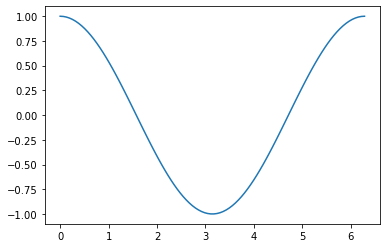